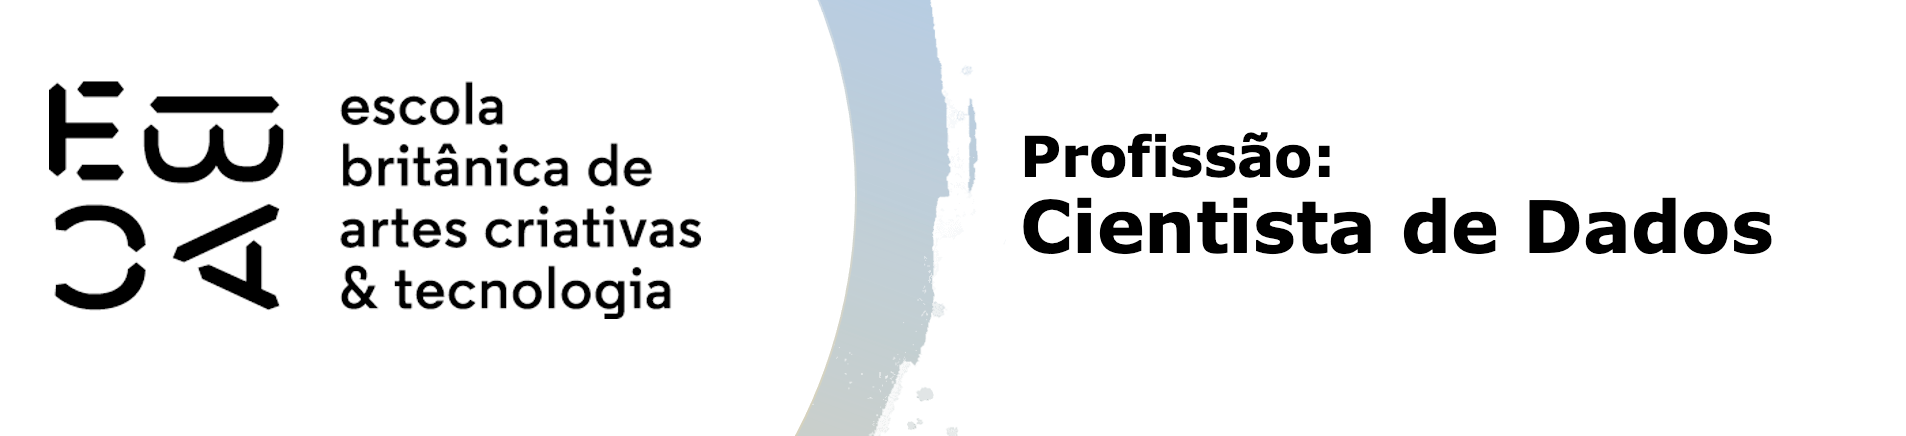

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, roc_curve
from scipy.stats import ks_2samp
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [12]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [13]:
# Converter a variável data_ref para datetime para facilitar a manipulação
df['data_ref'] = pd.to_datetime(df['data_ref'])

# Ordenar os dados pela data de referência, garantindo que a separação OOT seja correta
df = df.sort_values(by='data_ref')

# Definir a data limite para separar os três últimos meses como OOT
data_limite = df['data_ref'].max() - pd.DateOffset(months=3)

# Criar os conjuntos de treino e validação
train_df = df[df['data_ref'] <= data_limite]  # Dados antes dos últimos 3 meses
oot_df = df[df['data_ref'] > data_limite]    # Últimos 3 meses para validação

# Remover variáveis que não devem ser usadas na modelagem
variaveis_explicativas = df.columns.difference(['data_ref', 'index'])

# Exibir a divisão das bases
print(f"Tamanho da base de treino: {train_df.shape}")
print(f"Tamanho da base OOT: {oot_df.shape}")

Tamanho da base de treino: (600000, 15)
Tamanho da base OOT: (150000, 15)


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [14]:
# Descritiva básica univariada
print("\nNúmero total de linhas na base de dados:", df.shape[0])
print("\nNúmero de linhas para cada mês em data_ref:")
print(df['data_ref'].value_counts().sort_index())

# Descrição das variáveis quantitativas
descricao_quantitativas = df.describe()
print("\nResumo estatístico das variáveis quantitativas:")
print(descricao_quantitativas)

# Descrição das variáveis qualitativas
variaveis_qualitativas = df.select_dtypes(include=['object', 'bool']).columns
descricao_qualitativas = df[variaveis_qualitativas].describe()
print("\nResumo estatístico das variáveis qualitativas:")
print(descricao_qualitativas)


Número total de linhas na base de dados: 750000

Número de linhas para cada mês em data_ref:
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: data_ref, dtype: int64

Resumo estatístico das variáveis quantitativas:
               index     qtd_filhos          idade  tempo_emprego  \
count  750000.000000  750000.000000  750000.000000  624043.000000   
mean     8319.272793       0.433251      43.804733       7.748574   
std      4809.281774       0.739379      11.229868       6.687455   
min         0.000000       0.000000      22.000000       0.117808   
25%      4147.000000       0.000000      34.000000       3.049315   
50%      8324.000000       0.000000      43.000000       6.046575   
75%     12487.000000       1.000000      53.0

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

Variáveis numéricas disponíveis: Index(['index', 'qtd_filhos', 'idade', 'tempo_emprego',
       'qt_pessoas_residencia', 'renda', 'mau'],
      dtype='object')

Correlação das variáveis quantitativas com 'mau':
mau                      1.000000
index                    0.009360
qtd_filhos               0.007018
qt_pessoas_residencia    0.003878
idade                   -0.027989
renda                   -0.067978
tempo_emprego           -0.132118
Name: mau, dtype: float64


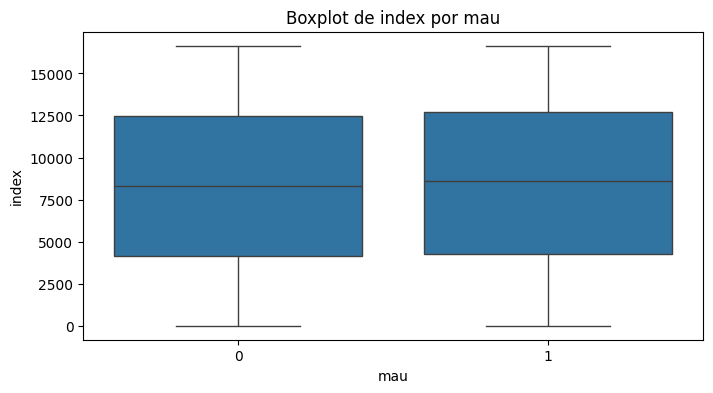

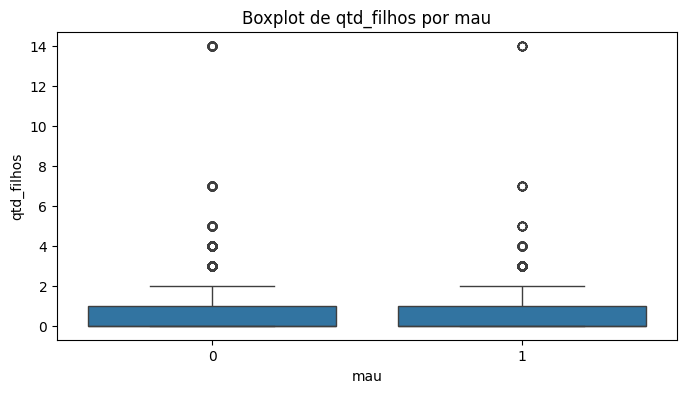

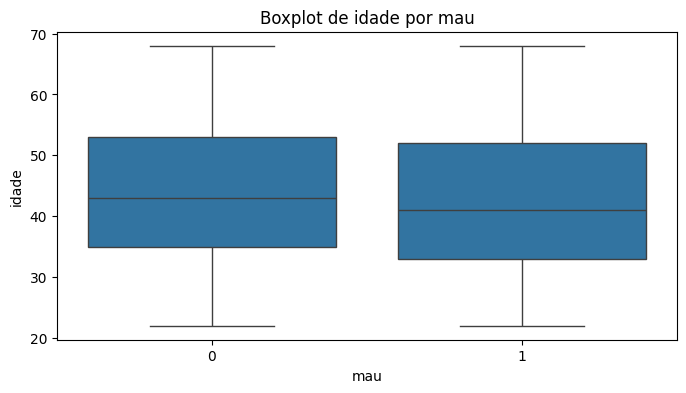

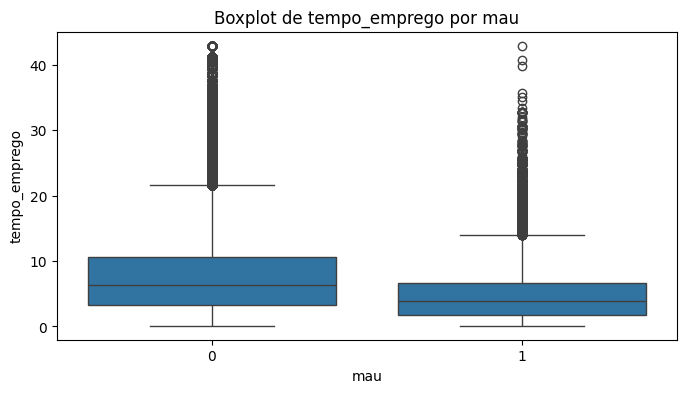

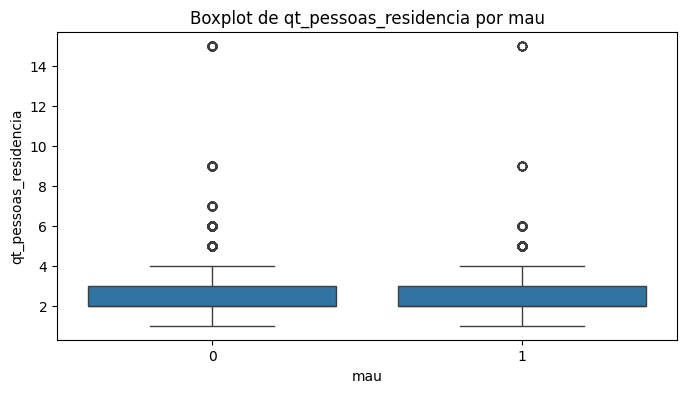

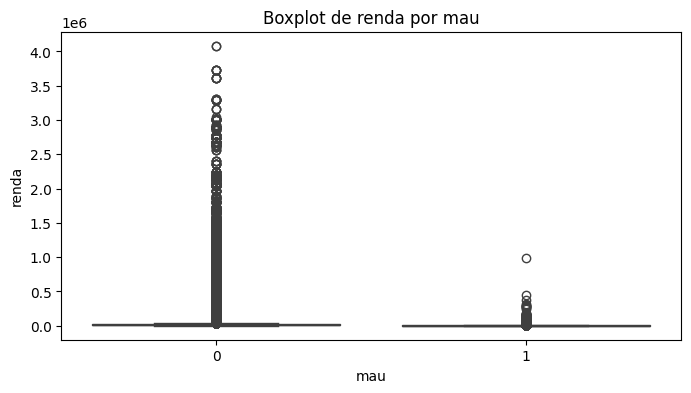

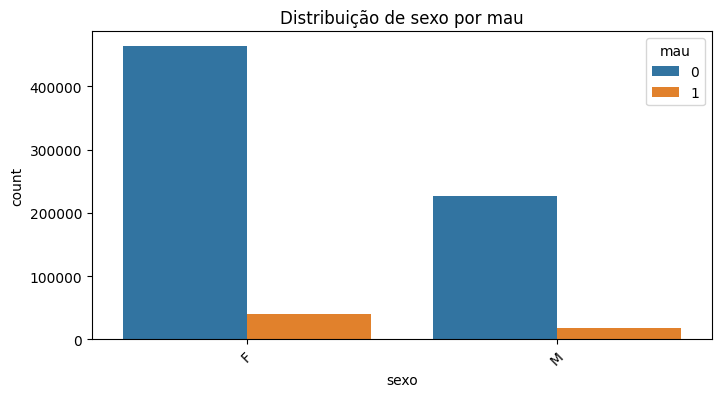

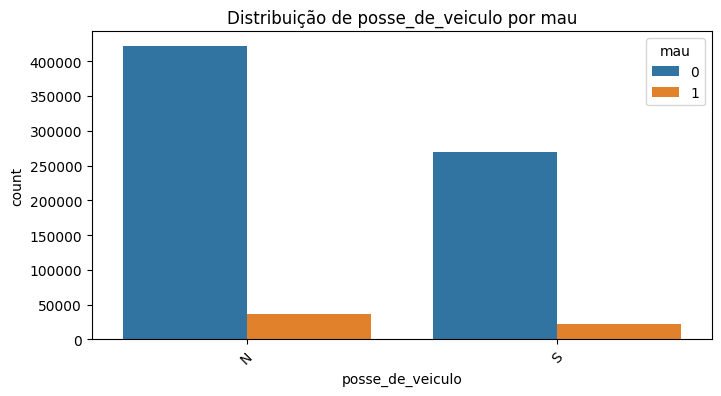

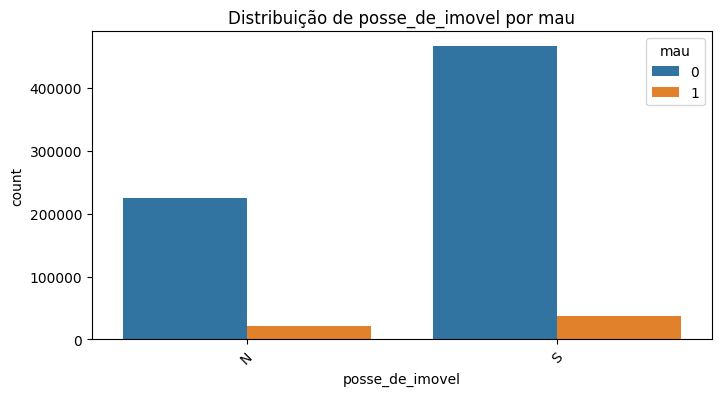

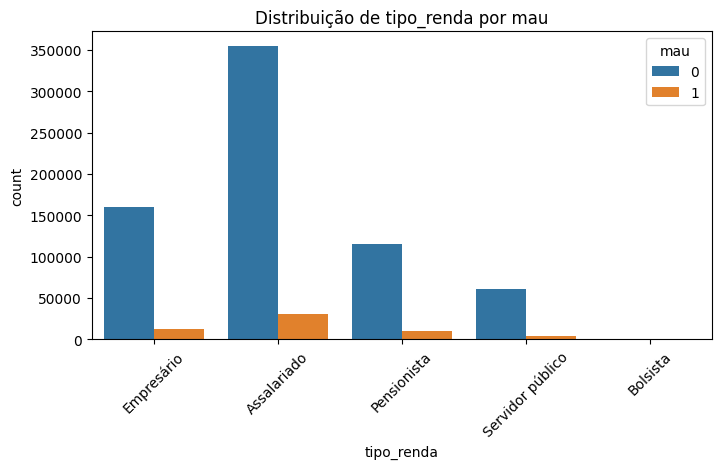

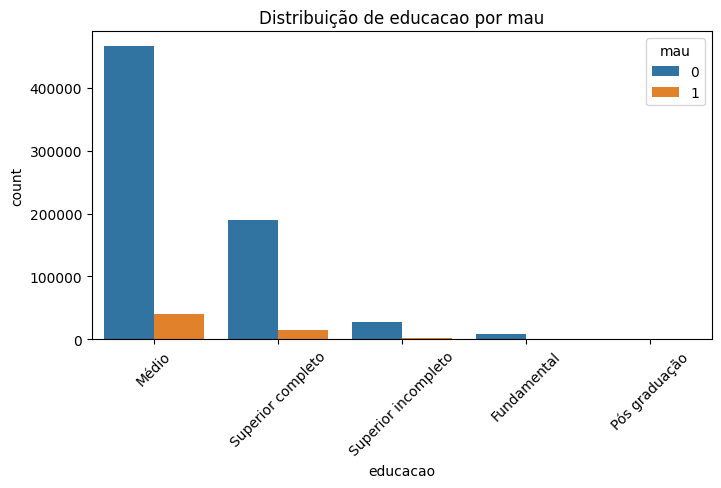

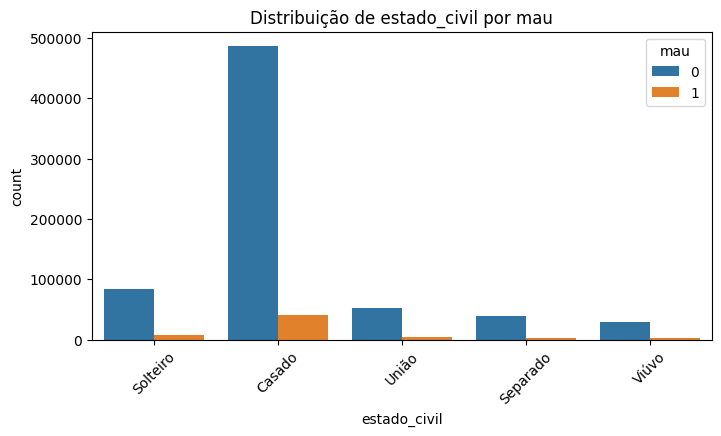

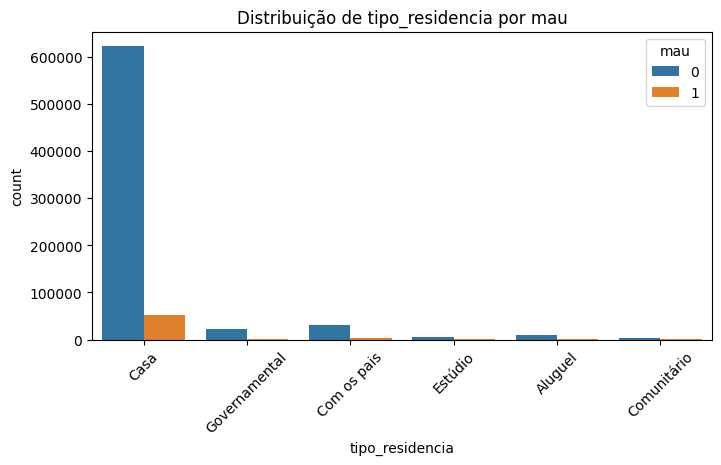

In [25]:
# Remover espaços extras dos nomes das colunas
df.columns = df.columns.str.strip()

# Forçar a conversão de 'mau' para numérico
df[variavel_target] = pd.to_numeric(df[variavel_target], errors='coerce').fillna(0).astype(int)

# Selecionar apenas variáveis numéricas para calcular a correlação
variaveis_numericas = df.select_dtypes(include=['number']).columns
print("Variáveis numéricas disponíveis:", variaveis_numericas)

# Calcular correlação
correlacoes = df[variaveis_numericas].corr()[variavel_target].sort_values(ascending=False)
print("\nCorrelação das variáveis quantitativas com 'mau':")
print(correlacoes)

# Boxplots para variáveis quantitativas
for col in variaveis_numericas:
    if col != variavel_target:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=df[variavel_target], y=df[col])
        plt.title(f"Boxplot de {col} por {variavel_target}")
        plt.show()

# Selecionar variáveis qualitativas
variaveis_qualitativas = df.select_dtypes(include=['object', 'category']).columns

# Gráficos de contagem para variáveis qualitativas
for col in variaveis_qualitativas:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=df[col], hue=df[variavel_target])
    plt.title(f"Distribuição de {col} por {variavel_target}")
    plt.xticks(rotation=45)
    plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [21]:
# Separar os últimos 3 meses como OOT
data_limite = df['data_ref'].max() - pd.DateOffset(months=3)
train_df = df[df['data_ref'] <= data_limite]
oot_df = df[df['data_ref'] > data_limite]

# Remover variáveis desnecessárias
variaveis_explicativas = df.columns.difference(['data_ref', 'index'])
variavel_target = 'mau'
df[variavel_target] = df[variavel_target].astype(int)

# Identificar variáveis numéricas e categóricas
variaveis_numericas = df.select_dtypes(include=['float64', 'int64']).columns.difference(['mau'])
variaveis_categoricas = df.select_dtypes(include=['object']).columns

# Tratar valores missing
imputer_numerico = SimpleImputer(strategy='median')
imputer_categorico = SimpleImputer(strategy='most_frequent')

# Criar pré-processamento para variáveis numéricas e categóricas
preprocessador = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', imputer_numerico), ('scaler', StandardScaler())]), variaveis_numericas),
        ('cat', Pipeline([('imputer', imputer_categorico), ('encoder', OneHotEncoder(handle_unknown='ignore'))]), variaveis_categoricas)
    ]
)

# Separar variáveis preditoras e alvo
X = df[variaveis_numericas.tolist() + variaveis_categoricas.tolist()]
y = df['mau']

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Criar pipeline com modelo de regressão logística
modelo = Pipeline([
    ('preprocessador', preprocessador),
    ('classificador', LogisticRegression(solver='liblinear'))
])

# Treinar modelo
modelo.fit(X_train, y_train)

# Fazer previsões
y_pred_train = modelo.predict(X_train)
y_proba_train = modelo.predict_proba(X_train)[:, 1]
y_pred_test = modelo.predict(X_test)
y_proba_test = modelo.predict_proba(X_test)[:, 1]

# Avaliação do modelo
print("\nRelatório de Classificação (Treino):")
print(classification_report(y_train, y_pred_train, zero_division=0))
print(f"Acurácia (Treino): {accuracy_score(y_train, y_pred_train):.4f}")

print("\nRelatório de Classificação (Teste):")
print(classification_report(y_test, y_pred_test, zero_division=0))
print(f"Acurácia (Teste): {accuracy_score(y_test, y_pred_test):.4f}")

# Calcular AUC-ROC
print(f"AUC-ROC (Treino): {roc_auc_score(y_train, y_proba_train):.4f}")
print(f"AUC-ROC (Teste): {roc_auc_score(y_test, y_proba_test):.4f}")

# Calcular KS
ks_train = ks_2samp(y_proba_train[y_train == 1], y_proba_train[y_train == 0]).statistic
ks_test = ks_2samp(y_proba_test[y_test == 1], y_proba_test[y_test == 0]).statistic
print(f"KS (Treino): {ks_train:.4f}")
print(f"KS (Teste): {ks_test:.4f}")

# Calcular Gini
gini_train = 2 * roc_auc_score(y_train, y_proba_train) - 1
gini_test = 2 * roc_auc_score(y_test, y_proba_test) - 1
print(f"Gini (Treino): {gini_train:.4f}")
print(f"Gini (Teste): {gini_test:.4f}")

# Avaliação na base OOT
X_oot = oot_df[variaveis_numericas.tolist() + variaveis_categoricas.tolist()]
y_oot = oot_df['mau']

# Aplicar o modelo na base OOT
y_pred_oot = modelo.predict(X_oot)
y_proba_oot = modelo.predict_proba(X_oot)[:, 1]

# Avaliação do modelo na base OOT
print(f"Acurácia (OOT): {accuracy_score(y_oot, y_pred_oot):.4f}")
print(f"AUC-ROC (OOT): {roc_auc_score(y_oot, y_proba_oot):.4f}")

# Calcular KS
ks_oot = ks_2samp(y_proba_oot[y_oot == 1], y_proba_oot[y_oot == 0]).statistic
print(f"KS (OOT): {ks_oot:.4f}")

# Calcular Gini
gini_oot = 2 * roc_auc_score(y_oot, y_proba_oot) - 1
print(f"Gini (OOT): {gini_oot:.4f}")



Relatório de Classificação (Treino):
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    553086
           1       0.00      0.00      0.00     46914

    accuracy                           0.92    600000
   macro avg       0.46      0.50      0.48    600000
weighted avg       0.85      0.92      0.88    600000

Acurácia (Treino): 0.9218

Relatório de Classificação (Teste):
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    138271
           1       0.00      0.00      0.00     11729

    accuracy                           0.92    150000
   macro avg       0.46      0.50      0.48    150000
weighted avg       0.85      0.92      0.88    150000

Acurácia (Teste): 0.9218
AUC-ROC (Treino): 0.7772
AUC-ROC (Teste): 0.7727
KS (Treino): 0.4171
KS (Teste): 0.4097
Gini (Treino): 0.5544
Gini (Teste): 0.5453
Acurácia (OOT): 0.8533
AUC-ROC (OOT): 0.7261
KS (OOT): 0.3308
Gini (OOT): 0.4521


## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

### Avaliação do Modelo de Credit Scoring

#### **Métricas do Modelo**
#### **Desempenho na Base de Treinamento**
- **Acurácia**: 92,18%
- **AUC-ROC**: 0.7772
- **KS**: 0.4171
- **Gini**: 0.5544

#### **Desempenho na Base de Teste**
- **Acurácia**: 92,18%
- **AUC-ROC**: 0.7727
- **KS**: 0.4097
- **Gini**: 0.5453

#### **Desempenho na Base OOT**
- **Acurácia**: 85,33%
- **AUC-ROC**: 0.7261
- **KS**: 0.3308
- **Gini**: 0.4521

---

### **Análise dos Resultados**
#### **Acurácia**
O modelo apresenta uma **acurácia de 92%** na base de treino e teste, mas cai para **85,33% na base OOT**. Isso sugere que o modelo pode estar **superajustado aos dados de treino e teste**, não generalizando tão bem para novos períodos.

#### **AUC-ROC e Gini**
- O **AUC-ROC** diminuiu de aproximadamente **0.77 para 0.72 na base OOT**, indicando que o modelo perdeu parte de sua capacidade de discriminação ao ser testado em novos dados.
- O **Gini**, que é derivado do AUC-ROC, também caiu de **0.55 para 0.45**, reforçando a queda na performance preditiva.

#### **KS (Kolmogorov-Smirnov)**
- O **KS caiu de 0.42 para 0.33 na base OOT**, indicando que a separação entre classes no conjunto de validação é mais fraca em comparação com treino e teste.
- Modelos bons geralmente apresentam KS **acima de 0.4**, o que significa que a performance na base OOT pode não ser satisfatória.

#### **Problema com a Classificação de Inadimplentes**
O **F1-score dos inadimplentes (classe 1) é 0**, ou seja, o modelo **não consegue prever corretamente clientes inadimplentes**. Isso indica que o modelo pode estar **extremamente enviesado para a classe majoritária (adimplentes - classe 0)**.

## Criar um pipeline utilizando o sklearn pipeline 

In [26]:
# Ordenar os dados pela data de referência
df = df.sort_values(by='data_ref')

# Separar os últimos 3 meses como OOT
data_limite = df['data_ref'].max() - pd.DateOffset(months=3)
train_df = df[df['data_ref'] <= data_limite]
oot_df = df[df['data_ref'] > data_limite]

# Remover variáveis desnecessárias
variavel_target = 'mau'
df.columns = df.columns.str.strip()
df[variavel_target] = pd.to_numeric(df[variavel_target], errors='coerce').fillna(0).astype(int)

# Identificar variáveis numéricas e categóricas
variaveis_numericas = df.select_dtypes(include=['number']).columns.difference([variavel_target])
variaveis_categoricas = df.select_dtypes(include=['object']).columns

# Pipeline de pré-processamento
preprocessador = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), variaveis_numericas),
        ('cat', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('encoder', OneHotEncoder(handle_unknown='ignore'))]), variaveis_categoricas)
    ]
)

# Separar variáveis preditoras e alvo
X = df[variaveis_numericas.tolist() + variaveis_categoricas.tolist()]
y = df[variavel_target]

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Criar pipeline com modelo de regressão logística
modelo = Pipeline([
    ('preprocessador', preprocessador),
    ('classificador', LogisticRegression(solver='liblinear'))
])

# Treinar modelo
modelo.fit(X_train, y_train)

# Fazer previsões
y_pred_train = modelo.predict(X_train)
y_proba_train = modelo.predict_proba(X_train)[:, 1]
y_pred_test = modelo.predict(X_test)
y_proba_test = modelo.predict_proba(X_test)[:, 1]

# Avaliação do modelo
print("\nRelatório de Classificação (Treino):")
print(classification_report(y_train, y_pred_train, zero_division=0))
print(f"Acurácia (Treino): {accuracy_score(y_train, y_pred_train):.4f}")

print("\nRelatório de Classificação (Teste):")
print(classification_report(y_test, y_pred_test, zero_division=0))
print(f"Acurácia (Teste): {accuracy_score(y_test, y_pred_test):.4f}")

# Calcular AUC-ROC
print(f"AUC-ROC (Treino): {roc_auc_score(y_train, y_proba_train):.4f}")
print(f"AUC-ROC (Teste): {roc_auc_score(y_test, y_proba_test):.4f}")

# Calcular KS
def calcular_ks(y_true, y_proba):
    return ks_2samp(y_proba[y_true == 1], y_proba[y_true == 0]).statistic

print(f"KS (Treino): {calcular_ks(y_train, y_proba_train):.4f}")
print(f"KS (Teste): {calcular_ks(y_test, y_proba_test):.4f}")

# Calcular Gini
def calcular_gini(y_true, y_proba):
    return 2 * roc_auc_score(y_true, y_proba) - 1

print(f"Gini (Treino): {calcular_gini(y_train, y_proba_train):.4f}")
print(f"Gini (Teste): {calcular_gini(y_test, y_proba_test):.4f}")

# Avaliação na base OOT
X_oot = oot_df[variaveis_numericas.tolist() + variaveis_categoricas.tolist()]
y_oot = oot_df[variavel_target]

# Aplicar o modelo na base OOT
y_pred_oot = modelo.predict(X_oot)
y_proba_oot = modelo.predict_proba(X_oot)[:, 1]

print(f"Acurácia (OOT): {accuracy_score(y_oot, y_pred_oot):.4f}")
print(f"AUC-ROC (OOT): {roc_auc_score(y_oot, y_proba_oot):.4f}")
print(f"KS (OOT): {calcular_ks(y_oot, y_proba_oot):.4f}")
print(f"Gini (OOT): {calcular_gini(y_oot, y_proba_oot):.4f}")


Relatório de Classificação (Treino):
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    553086
           1       0.00      0.00      0.00     46914

    accuracy                           0.92    600000
   macro avg       0.46      0.50      0.48    600000
weighted avg       0.85      0.92      0.88    600000

Acurácia (Treino): 0.9218

Relatório de Classificação (Teste):
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    138271
           1       0.00      0.00      0.00     11729

    accuracy                           0.92    150000
   macro avg       0.46      0.50      0.48    150000
weighted avg       0.85      0.92      0.88    150000

Acurácia (Teste): 0.9218
AUC-ROC (Treino): 0.7766
AUC-ROC (Teste): 0.7741
KS (Treino): 0.4155
KS (Teste): 0.4142
Gini (Treino): 0.5532
Gini (Teste): 0.5483
Acurácia (OOT): 0.8533
AUC-ROC (OOT): 0.7258
KS (OOT): 0.3299
Gini (OOT): 0.4516


## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [27]:
# Converter a variável data_ref para datetime para facilitar a manipulação
df['data_ref'] = pd.to_datetime(df['data_ref'])

# Remover a variável 'index' por ser apenas um identificador
df = df.drop(columns=['index'], errors='ignore')

# Identificar variáveis numéricas e categóricas
variaveis_numericas = df.select_dtypes(include=['float64', 'int64']).columns.difference(['mau'])
variaveis_categoricas = df.select_dtypes(include=['object']).columns

# Verificar a presença de valores nulos
dados_nulos = df.isnull().sum()
print("Valores nulos por variável:")
print(dados_nulos[dados_nulos > 0])

# Definir estratégias de imputação
imputer_numerico = SimpleImputer(strategy='median')  # Substitui nulos por mediana
imputer_categorico = SimpleImputer(strategy='most_frequent')  # Substitui nulos pelo valor mais frequente

# Criar pipeline para pré-processamento
preprocessador = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', imputer_numerico), ('scaler', StandardScaler())]), variaveis_numericas),
        ('cat', Pipeline([('imputer', imputer_categorico), ('encoder', OneHotEncoder(handle_unknown='ignore'))]), variaveis_categoricas)
    ]
)

# Aplicar o pipeline na base
df_preprocessado = preprocessador.fit_transform(df)

print("Pré-processamento concluído.")

Valores nulos por variável:
tempo_emprego    125957
dtype: int64
Pré-processamento concluído.


### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [28]:
# Identificação e tratamento de outliers
for col in variaveis_numericas:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    limite_inferior = q1 - 1.5 * iqr
    limite_superior = q3 + 1.5 * iqr
    
    # Substituir outliers por limites inferior/superior
    df[col] = np.where(df[col] < limite_inferior, limite_inferior, df[col])
    df[col] = np.where(df[col] > limite_superior, limite_superior, df[col])

# Criar pipeline para pré-processamento
preprocessador = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', imputer_numerico), ('scaler', StandardScaler())]), variaveis_numericas),
        ('cat', Pipeline([('imputer', imputer_categorico), ('encoder', OneHotEncoder(handle_unknown='ignore'))]), variaveis_categoricas)
    ]
)

# Aplicar o pipeline na base
df_preprocessado = preprocessador.fit_transform(df)

print("Pré-processamento concluído, incluindo tratamento de outliers.")

Pré-processamento concluído, incluindo tratamento de outliers.


### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [29]:
# Separar variáveis preditoras e alvo
X = df[variaveis_numericas.tolist() + variaveis_categoricas.tolist()]
y = df['mau']

# Dividir a base em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Aplicar pré-processamento na base de treino
X_train_transf = preprocessador.fit_transform(X_train)
X_test_transf = preprocessador.transform(X_test)

# Obter os nomes das colunas após a transformação
nomes_numericos = variaveis_numericas.tolist()
nomes_categoricos = preprocessador.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(variaveis_categoricas).tolist()
nomes_finais = nomes_numericos + nomes_categoricos

# Treinar modelo RandomForestClassifier
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_rf.fit(X_train_transf, y_train)

# Selecionar variáveis mais importantes
seletor = SelectFromModel(modelo_rf, threshold='median', prefit=True)
variaveis_selecionadas = np.array(nomes_finais)[seletor.get_support()]

print("Variáveis selecionadas:", variaveis_selecionadas)
print("Pré-processamento e seleção de variáveis concluídos.")

Variáveis selecionadas: ['idade' 'qt_pessoas_residencia' 'qtd_filhos' 'renda' 'tempo_emprego'
 'sexo_F' 'posse_de_veiculo_N' 'posse_de_veiculo_S'
 'tipo_renda_Assalariado' 'tipo_renda_Empresário' 'educacao_Médio'
 'educacao_Superior completo' 'estado_civil_Casado'
 'estado_civil_Solteiro' 'estado_civil_União' 'tipo_residencia_Casa']
Pré-processamento e seleção de variáveis concluídos.


### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [30]:
# Aplicar PCA para reduzir a dimensionalidade para 5 componentes
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_transf)
X_test_pca = pca.transform(X_test_transf)

# Treinar modelo RandomForestClassifier com dados reduzidos
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_rf.fit(X_train_pca, y_train)

print("PCA aplicado: Redução para 5 componentes concluída.")

PCA aplicado: Redução para 5 componentes concluída.


### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [31]:
variaveis_categoricas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']

# Criar dummies para variáveis categóricas
df = pd.get_dummies(df, columns=variaveis_categoricas, drop_first=True)

df.head()

,data_ref,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,sexo_M,posse_de_veiculo_S,posse_de_imovel_S,...,educacao_Superior incompleto,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
0,2015-01-01,0.0,43.0,6.873973,1.0,2515.39,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
4,2015-01-01,0.0,31.0,8.432877,1.0,2891.08,0,0,1,0,...,1,0,1,0,0,1,0,0,0,0
5,2015-01-01,1.0,45.0,20.884932,3.0,25387.16,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
6,2015-01-01,2.0,38.0,9.926027,4.0,3544.27,0,0,1,1,...,0,0,0,0,0,1,0,0,0,0
7,2015-01-01,0.0,40.0,8.690411,2.0,5331.02,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0


### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

### Treinar um modelo de regressão logistica com o resultado

### Salvar o pickle file do modelo treinado

In [32]:
import pickle

# Função para carregar dados
def carregar_dados(file_path='credit_scoring.ftr'):
    df = pd.read_feather(file_path)
    df['data_ref'] = pd.to_datetime(df['data_ref'])
    df = df.drop(columns=['index', 'data_ref'], errors='ignore')  # Removendo data_ref
    return df

# Função de pré-processamento
def preprocessamento(df):
    variaveis_numericas = df.select_dtypes(include=['float64', 'int64']).columns.difference(['mau'])
    variaveis_categoricas = df.select_dtypes(include=['object']).columns  # Considerar todas as categóricas
    
    return df, variaveis_numericas, variaveis_categoricas

# Função principal para executar o pipeline
def executar_pipeline():
    df = carregar_dados()
    df, variaveis_numericas, variaveis_categoricas = preprocessamento(df)
    
    # Separar variáveis preditoras e alvo
    X = df.drop(columns=['mau'])
    y = df['mau']
    
    # Dividir a base em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Criar pipeline de pré-processamento
    preprocessador = ColumnTransformer([
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), variaveis_numericas),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), variaveis_categoricas)
    ])
    
    # Criar pipeline final com regressão logística
    pipeline = Pipeline([
        ('preprocessador', preprocessador),
        ('pca', PCA(n_components=5)),
        ('modelo', LogisticRegression(max_iter=1000, random_state=42))
    ])
    
    # Treinar modelo
    pipeline.fit(X_train, y_train)
    
    print("Pipeline concluído com sucesso.")
    
    # Salvar modelo treinado como pickle
    with open('modelo_regressao_logistica.pkl', 'wb') as f:
        pickle.dump(pipeline, f)
    
    print("Modelo salvo como 'modelo_regressao_logistica.pkl'.")
    
    return pipeline, X_test, y_test

# Executar pipeline
pipeline, X_test, y_test = executar_pipeline()

Pipeline concluído com sucesso.
Modelo salvo como 'modelo_regressao_logistica.pkl'.


# Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



### Salvar o arquivo do modelo treinado

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(643124, 17)"
4,Transformed data shape,"(643124, 36)"
5,Transformed train set shape,"(450186, 36)"
6,Transformed test set shape,"(192938, 36)"
7,Ordinal features,2
8,Numeric features,9
9,Date features,1


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Test,0.9117,0.7578,0.0276,0.5304,0.0524,0.0441,0.1058


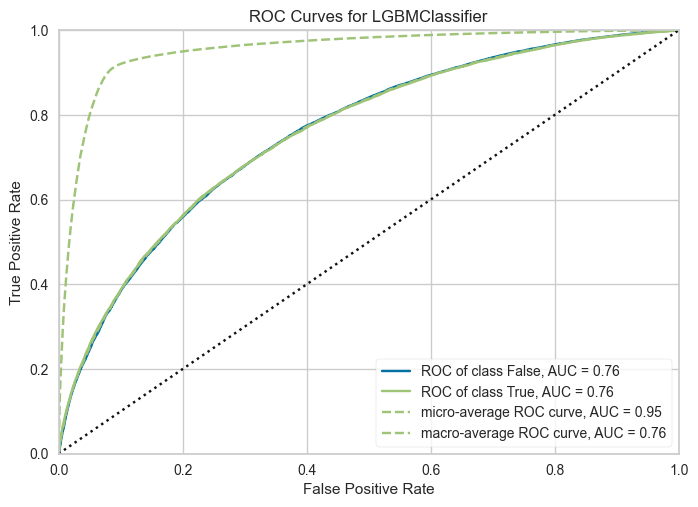

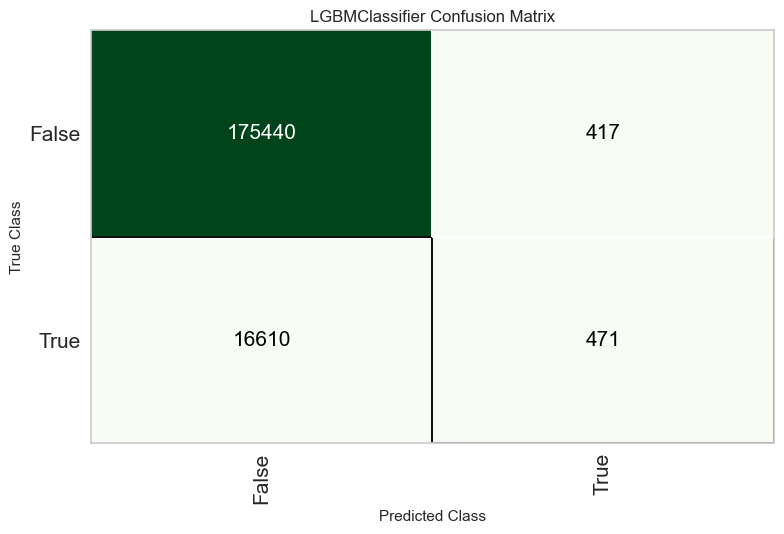

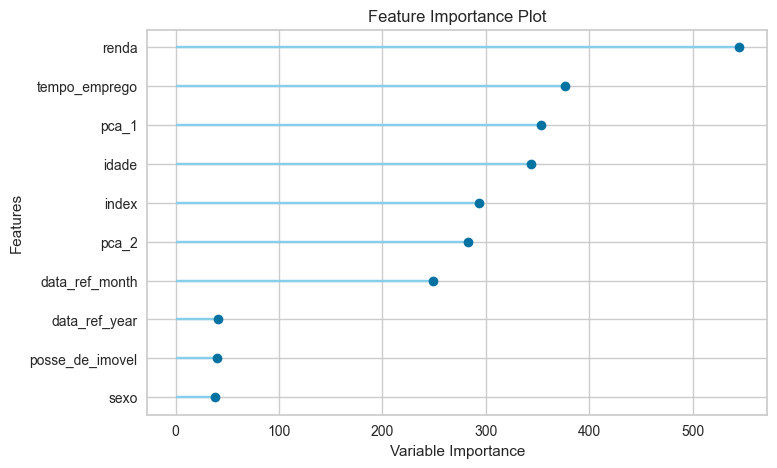

Transformation Pipeline and Model Successfully Saved


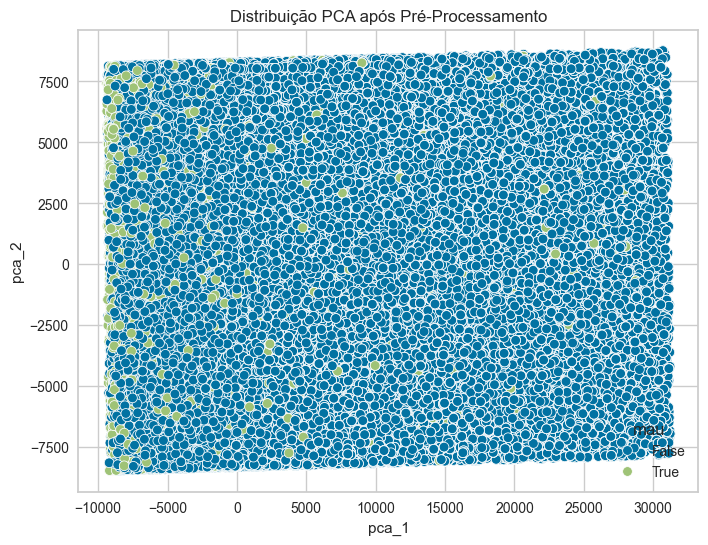

In [33]:
from pycaret.classification import *

# Carregar os dados
df = pd.read_feather('credit_scoring.ftr')

# Função de pré-processamento
def preprocessamento(df):
    df = df.copy()
    
    # Substituição de nulos
    df.fillna(df.median(numeric_only=True), inplace=True)
    
    # Remoção de outliers (usando IQR apenas em colunas numéricas)
    numeric_cols = df.select_dtypes(include=['number']).columns
    Q1 = df[numeric_cols].quantile(0.25)
    Q3 = df[numeric_cols].quantile(0.75)
    IQR = Q3 - Q1
    df = df[~((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
    
    # Criando dummies para a variável 'posse_de_veiculo'
    df = pd.get_dummies(df, columns=['posse_de_veiculo'], drop_first=True)
    
    # Aplicando PCA manualmente para reduzir a dimensionalidade
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(df[numeric_cols])
    df['pca_1'] = pca_result[:, 0]
    df['pca_2'] = pca_result[:, 1]
    
    return df

# Aplicando o pré-processamento
df = preprocessamento(df)

# Configuração do ambiente PyCaret (otimizado)
setup(
    data=df, 
    target='mau', 
    session_id=123, 
    normalize=True, 
    transformation=True, 
    n_jobs=1,  # Limitar ainda mais o uso de CPU
    fold=3,  # Reduzindo ainda mais os folds da validação cruzada
    remove_multicollinearity=False,  # Desativar remoção de multicolinearidade para economizar memória
    use_gpu=False  
)

# Treinamento do modelo LightGBM (sem validação cruzada para evitar consumo excessivo)
model = create_model('lightgbm', cross_validation=False)

# Avaliação do modelo
plot_model(model, plot='auc')
plot_model(model, plot='confusion_matrix')
plot_model(model, plot='feature')

# Finalizando o pipeline
final_model = finalize_model(model)

# Salvando o pipeline
df_transformed = pull()
save_model(final_model, 'model_final')

# Exibição dos gráficos finais
plt.figure(figsize=(8,6))
sns.scatterplot(x=df['pca_1'], y=df['pca_2'], hue=df['mau'])
plt.title('Distribuição PCA após Pré-Processamento')
plt.show()

### Avaliação do Modelo de Credit Scoring

#### 1. Introdução
Análise e avaliação do modelo de classificação treinado para prever o risco de crédito (*credit scoring*). O modelo utilizado foi o **LightGBM**, treinado e avaliado com a biblioteca **PyCaret**.

#### 2. Pré-Processamento

O conjunto de dados passou por um processo de pré-processamento que incluiu:
- **Imputação de valores nulos**: Utilizando a mediana para variáveis numéricas.
- **Remoção de outliers**: Aplicando o método do IQR (Interquartile Range) para eliminar valores extremos.
- **Codificação de variáveis categóricas**: Conversão da variável `posse_de_veiculo` para *dummies*.
- **Redução de dimensionalidade**: Aplicação do **PCA (Principal Component Analysis)** para condensar as variáveis numéricas em dois componentes principais.

#### 3. Configuração do Modelo no PyCaret

O modelo foi configurado com os seguintes parâmetros:
- **Target:** `mau` (variável binária indicando inadimplência)
- **Normalização:** `True` (usando *z-score*)
- **Transformação de dados:** `Yeo-Johnson`
- **Número de folds para validação cruzada:** `3`
- **Número de jobs na CPU:** `1`
- **Uso de GPU:** `False`

### 4. Desempenho do Modelo

#### 4.1 Curva ROC

A Curva ROC indica que o modelo obteve:
- **AUC (Área Sob a Curva) para a classe positiva (True):** 0.76
- **AUC para a classe negativa (False):** 0.76
- **AUC micro-média:** 0.95
- **AUC macro-média:** 0.76

> O AUC de 0.76 indica um desempenho razoável na discriminação entre bons e maus pagadores.

#### 4.2 Matriz de Confusão

| Verdadeiro \ Predito | Falso (0) | Verdadeiro (1) |
|----------------------|-----------|-----------|
| **Falso (0)** | 175440 | 417 |
| **Verdadeiro (1)** | 16610 | 471 |

- O modelo tem **alta precisão para identificar clientes que não são inadimplentes**, mas uma **baixa taxa de recall para inadimplentes**, indicando que muitos deles não foram corretamente identificados.

#### 4.3 Importância das Variáveis

As variáveis mais importantes para o modelo foram:
1. **Renda** (variável mais relevante)
2. **Tempo de emprego**
3. **Componentes principais do PCA (pca_1, pca_2)**
4. **Idade**
5. **Posse de imóvel**

Isso indica que renda e estabilidade profissional são fatores determinantes para prever o risco de crédito.

#### 4.4 Métricas de Avaliação

| Métrica | Valor |
|---------|------|
| **Acurácia** | 0.9117 |
| **AUC** | 0.7578 |
| **Recall** | 0.0276 |
| **Precisão** | 0.5304 |
| **F1-Score** | 0.0524 |
| **Kappa** | 0.0441 |
| **MCC** | 0.1058 |

> O modelo apresenta **alta acurácia**, mas sofre com **baixo recall**, indicando que não é eficaz na identificação de inadimplentes.

### 5. Conclusão e Melhorias Futuras

O modelo LightGBM apresenta um desempenho sólido em termos de **precisão geral**, mas **tem dificuldade em identificar inadimplentes (baixa recall)**. Isso pode ser devido ao desbalanceamento da classe alvo.

Possíveis melhorias incluem:
- **Técnicas de balanceamento de classes**, como *oversampling* (SMOTE) ou *undersampling*.
- **Ajuste de hiperparâmetros do modelo**, explorando diferentes configurações do LightGBM.
- **Testar outras abordagens de engenharia de atributos**, para enriquecer o conjunto de dados com informações mais relevantes.

Apesar dessas limitações, o modelo já fornece um **bom ponto de partida para análise de risco de crédito** e pode ser refinado para melhores resultados.


# Projeto Final

1. Subir no GITHUB todos os jupyter notebooks/códigos que você desenvolveu nesse ultimo módulo
1. Gerar um arquivo python (.py) com todas as funções necessárias para rodar no streamlit a escoragem do arquivo de treino
    - Criar um .py
    - Criar um carregador de csv no streamlit 
    - Subir um csv no streamlit 
    - Criar um pipeline de pré processamento dos dados
    - Utilizar o modelo treinado para escorar a base 
        - nome_arquivo = 'model_final.pkl'
1. Gravar um vídeo da tela do streamlit em funcionamento (usando o próprio streamlit (temos aula disso) ou qlqr outra forma de gravação).
1. Subir no Github o vídeo de funcionamento da ferramenta como README.md.
1. Subir no Github os códigos desenvolvidos. 
1. Enviar links do github para o tutor corrigir.